# HAR LSTM training 

In [2]:
# HAR classification 
# Author: Burak Himmetoglu
# 8/15/2017

import pandas as pd 
import numpy as np
import os

def read_data(data_path, split = "train"):
	""" Read data """

	# Fixed params
	n_class = 6
	n_steps = 128

	# Paths
	path_ = os.path.join(data_path, split)
	path_signals = os.path.join(path_, "Inertial_Signals")

	# Read labels and one-hot encode
	label_path = os.path.join(path_, "y_" + split + ".txt")
	labels = pd.read_csv(label_path, header = None)

	# Read time-series data
	channel_files = os.listdir(path_signals)
	channel_files.sort()
	n_channels = len(channel_files)
	posix = len(split) + 5

	# Initiate array
	list_of_channels = []
	X = np.zeros((len(labels), n_steps, n_channels))
	i_ch = 0
	for fil_ch in channel_files:
		channel_name = fil_ch[:-posix]
		dat_ = pd.read_csv(os.path.join(path_signals,fil_ch), delim_whitespace = True, header = None)
		X[:,:,i_ch] = dat_.as_matrix()

		# Record names
		list_of_channels.append(channel_name)

		# iterate
		i_ch += 1

	# Return 
	return X, labels[0].values, list_of_channels

def standardize(train, test):
	""" Standardize data """

	# Standardize train and test
	X_train = (train - np.mean(train, axis=0)[None,:,:]) / np.std(train, axis=0)[None,:,:]
	X_test = (test - np.mean(test, axis=0)[None,:,:]) / np.std(test, axis=0)[None,:,:]

	return X_train, X_test

def one_hot(labels, n_class = 6):
	""" One-hot encoding """
	expansion = np.eye(n_class)
	y = expansion[:, labels-1].T
	assert y.shape[1] == n_class, "Wrong number of labels!"

	return y

def get_batches(X, y, batch_size = 100):
	""" Return a generator for batches """
	n_batches = len(X) // batch_size
	X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

	# Loop over batches and yield
	for b in range(0, len(X), batch_size):
		yield X[b:b+batch_size], y[b:b+batch_size]

## Prepare data

In [3]:
X_train, labels_train, list_ch_train = read_data(data_path="/home/arasdar/datasets/har-data/", split="train") # train
X_test, labels_test, list_ch_test = read_data(data_path="/home/arasdar/datasets/har-data/", split="test") # test

assert list_ch_train == list_ch_test, "Mistmatch in channels!"

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [4]:
# # Standardize
# X_train, X_test = standardize(X_train, X_test)
# print(X_train.shape, X_test.shape)

Train/Validation Split

In [5]:
from sklearn.model_selection import train_test_split

X_tr, X_vld, lab_tr, lab_vld = train_test_split(X_train, labels_train,
                                                stratify = labels_train,
                                                random_state = 123)

In [6]:
print(X_tr.shape, X_tr.dtype)
print(X_vld.shape, X_vld.dtype)
print(lab_tr.shape, lab_tr.dtype)
print(lab_vld.shape, lab_vld.dtype)

(5514, 128, 9) float64
(1838, 128, 9) float64
(5514,) int64
(1838,) int64


One-hot encoding:

In [7]:
# y_tr = one_hot(lab_tr)
# y_vld = one_hot(lab_vld)
# y_test = one_hot(labels_test)

In [8]:
print(X_tr.shape, X_tr.dtype)
print(X_vld.shape, X_vld.dtype)
print(X_test.shape, X_test.dtype)
# print(y_tr.shape, y_tr.dtype)
# print(y_vld.shape, y_vld.dtype)
# print(y_test.shape, y_test.dtype)

(5514, 128, 9) float64
(1838, 128, 9) float64
(2947, 128, 9) float64


### Hyperparameters

In [9]:
# Imports
import tensorflow as tf

lstm_size = 27         # 3 times the amount of channels
lstm_layers = 1        # Number of layers
batch_size = 600       # Batch size
seq_len = 128          # Number of steps
learning_rate = 0.001  # Learning rate (default is 0.001)
epochs = 100

# Fixed
n_classes = 6
n_channels = 9

### Construct the graph
Placeholders

In [11]:
# graph = tf.Graph()

# Construct placeholders
# with graph.as_default():
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs')
indices_ = tf.placeholder(tf.int32, [None], name = 'indices')
#     keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
#     learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

Construct inputs to LSTM

In [12]:
# with graph.as_default():
# Construct the LSTM inputs and LSTM cells
print(inputs_.shape)
lstm_in = tf.transpose(inputs_, [1,0,2]) # reshape into (seq_len, N, channels)
print(lstm_in.shape)
lstm_in = tf.reshape(lstm_in, [-1, n_channels]) # Now (seq_len*N, n_channels)
print(lstm_in.shape)

#     # To cells
#     lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None) # or tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh?

# Open up the tensor into a list of seq_len pieces
lstm_in = tf.split(lstm_in, seq_len, 0)
print(len(lstm_in), lstm_in[0].shape)

# Add LSTM layers
lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
#     drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob_)
cell = tf.contrib.rnn.MultiRNNCell([lstm] * lstm_layers)
initial_state = cell.zero_state(batch_size, tf.float32)

(?, 128, 9)
(128, ?, 9)
(?, 9)
128 (?, 9)


Define forward pass, cost function and optimizer:

In [13]:
# with graph.as_default():
# with tf.variable_scope('RNN', reuse=True):
outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32,
                                                 initial_state = initial_state)

# We only need the last output tensor to pass into a classifier
logits = tf.layers.dense(outputs[-1], n_classes, name='logits')

# Cost function and optimizer
labels_ = tf.one_hot(depth=n_classes, indices=indices_)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels_))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost) # No grad clipping

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [14]:
print(len(outputs), outputs[0].shape)

128 (600, 27)


In [15]:
print(cost)

Tensor("Mean:0", shape=(), dtype=float32)


In [16]:
print(logits)

Tensor("logits/BiasAdd:0", shape=(600, 6), dtype=float32)


### Train the network

In [17]:
if (os.path.exists('checkpoints') == False):
    !mkdir checkpoints

In [18]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

# with graph.as_default():
saver = tf.train.Saver()

with tf.Session() as sess:
    # Initialize the global variable instead of loading them or if there is nothing to load.
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs):
        # Initialize 
        state = sess.run(initial_state)
        
        # Training
        train_acc_ = []
        train_loss_ = []
        # Loop over batches
        for x,y in get_batches(X_tr, lab_tr, batch_size):
            
            # Feed dictionary
            feed = {inputs_ : x, indices_ : y, initial_state : state}
            
            loss, _ , state, acc = sess.run([cost, optimizer, final_state, accuracy], 
                                             feed_dict = feed)
            train_acc_.append(acc)
            train_loss_.append(loss)
            
        # Print at each 5 iters
        print("Epoch: {}/{}".format(e, epochs),
              "Train loss: {}".format(np.mean(train_loss_)),
              "Train acc: {}".format(np.mean(train_acc_)))

        # Store
        train_acc.append(np.mean(train_acc_))
        train_loss.append(np.mean(train_loss_))
        
        # Validation
        # Initiate for validation set
        val_state = sess.run(cell.zero_state(batch_size, tf.float32))
        val_acc_ = []
        val_loss_ = []
        for x_v, y_v in get_batches(X_vld, lab_vld, batch_size):
            # Feed
            feed = {inputs_ : x_v, indices_ : y_v, initial_state : val_state}

            # Loss
            loss_v, state_v, acc_v = sess.run([cost, final_state, accuracy], feed_dict = feed)

            val_acc_.append(acc_v)
            val_loss_.append(loss_v)

        # Print info
        print("Epoch: {}/{}".format(e, epochs),
              "Valid loss: {}".format(np.mean(val_loss_)),
              "Valid acc: {}".format(np.mean(val_acc_)))
                
        # Store
        validation_acc.append(np.mean(val_acc_))
        validation_loss.append(np.mean(val_loss_))
            
    saver.save(sess,"checkpoints/har-lstm.ckpt")

Epoch: 0/100 Train loss: 1.4420380592346191 Train acc: 0.2433333396911621
Epoch: 0/100 Valid loss: 1.4158622026443481 Valid acc: 0.3149999976158142
Epoch: 1/100 Train loss: 1.3967152833938599 Train acc: 0.27814817428588867
Epoch: 1/100 Valid loss: 1.371342658996582 Valid acc: 0.23555554449558258
Epoch: 2/100 Train loss: 1.352476954460144 Train acc: 0.22870370745658875
Epoch: 2/100 Valid loss: 1.330086588859558 Valid acc: 0.23000000417232513
Epoch: 3/100 Train loss: 1.3104784488677979 Train acc: 0.26333335041999817
Epoch: 3/100 Valid loss: 1.287522315979004 Valid acc: 0.31333333253860474
Epoch: 4/100 Train loss: 1.2622880935668945 Train acc: 0.30407407879829407
Epoch: 4/100 Valid loss: 1.2305455207824707 Valid acc: 0.33444443345069885
Epoch: 5/100 Train loss: 1.2002778053283691 Train acc: 0.3403703272342682
Epoch: 5/100 Valid loss: 1.1772414445877075 Valid acc: 0.32111111283302307
Epoch: 6/100 Train loss: 1.1464067697525024 Train acc: 0.35185182094573975
Epoch: 6/100 Valid loss: 1.11754

Epoch: 55/100 Train loss: 0.44507959485054016 Train acc: 0.6927778720855713
Epoch: 55/100 Valid loss: 0.41584837436676025 Valid acc: 0.722777783870697
Epoch: 56/100 Train loss: 0.4075210988521576 Train acc: 0.7216666340827942
Epoch: 56/100 Valid loss: 0.4131421148777008 Valid acc: 0.7155554890632629
Epoch: 57/100 Train loss: 0.41288816928863525 Train acc: 0.7157407402992249
Epoch: 57/100 Valid loss: 0.40695372223854065 Valid acc: 0.6988888382911682
Epoch: 58/100 Train loss: 0.4117943048477173 Train acc: 0.707777738571167
Epoch: 58/100 Valid loss: 0.43824777007102966 Valid acc: 0.6938889026641846
Epoch: 59/100 Train loss: 0.4498891234397888 Train acc: 0.6898148059844971
Epoch: 59/100 Valid loss: 0.4570913016796112 Valid acc: 0.6700000166893005
Epoch: 60/100 Train loss: 0.44622671604156494 Train acc: 0.6899999380111694
Epoch: 60/100 Valid loss: 0.4166242182254791 Valid acc: 0.6894444823265076
Epoch: 61/100 Train loss: 0.38929441571235657 Train acc: 0.7144443988800049
Epoch: 61/100 Valid 

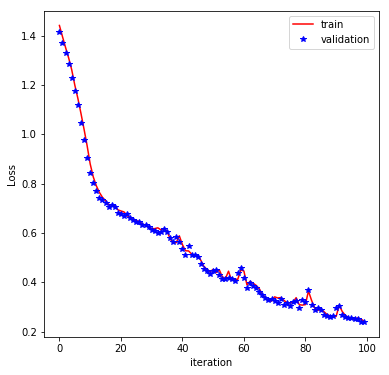

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plot training and test loss
plt.figure(figsize = (6,6))
plt.plot(np.array(train_loss), 'r-', np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

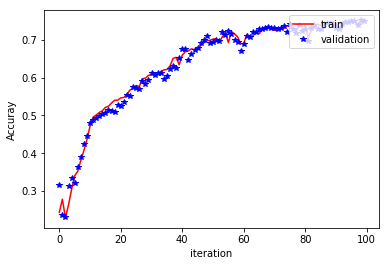

In [21]:
# Plot Accuracies
plt.plot(np.array(train_acc), 'r-', validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Evaluate on test set

In [25]:
test_acc = []

with tf.Session() as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    
    for x_t, y_t in get_batches(X_test, labels_test, batch_size):
        feed = {inputs_: x_t,
                indices_: y_t,
                initial_state: test_state}
        
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints/har-lstm.ckpt
Test accuracy: 0.685833
